## Homework Three

In this assignment, you’ll deepen your understanding of linear regression by learning how to use a held-out evaluation set to guide model selection in polynomial regression. By comparing training performance with performance on unseen data, you’ll see how increasing model complexity can move a model from underfitting to overfitting—and how an evaluation set provides a practical way to find the “sweet spot” in between.

For now, we’ll use a **single held-out evaluation set** to compare models and study generalization behavior. This simplifies the workflow so we can focus on how evaluating performance on unseen data helps us assess how well a model generalizes.

In later lessons, we will refine this approach by introducing a **separate validation set** for hyperparameter tuning, and reserving the **test set** strictly for final, one-time performance assessment. This protocol is standard throughout machine learning.

In the second part of the assignment, you’ll move beyond simple polynomial terms and explore **feature engineering** using non-linear transformations. You will create new predictors—such as log-scaled and interaction features—from the original inputs, and evaluate how these engineered variables **may** improve a linear model’s ability to explain and predict MPG.

To introduce a metaphor we’ll use throughout the course, this assignment begins to build a **toolbox** of machine learning techniques—methods you can draw on to make linear models more expressive and better suited to complex data.

There are 9 graded questions worth 6 points each, and you receive an additional 1 point for completing the homework.


In [107]:
# Useful imports and utilities

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import kagglehub
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing,make_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from tqdm import tqdm
from math import isclose

# globals

random_seed = 42       

### Problem One:  Model Selection for Polynomial Regression using Held-Out Evaluation Sets

This week’s video explores the challenge of model selection in polynomial regression: how do we determine the best polynomial degree for our data? As we saw, increasing model complexity (in this case, polynomial degree) generally reduces training MSE. However, this does not necessarily mean better generalization, so: 

- How do we select a model that performs well on new data?
- How do we strike the right balance between:
   - Underfitting (high bias, low variance), and
   - Overfitting (low bias, high variance)?

To address this, we introduce **held-out evaluation sets** and examine how evaluating models on unseen data provides a more reliable measure of generalization. 


### Prelude

The function `make_poly_model` (based on `make_regression`) will generate synthetic datasets suitable for polynomial regression with various characteristics:

- `n_samples`: number of samples
- `degree`: degree of the underlying polynomial model (with no noise)
- `noise`: standard deviation of the noise added to the model
- `show_data`, `show_model`: whether to show a plot of the dataset and the underlying model
- `random_state`: random seed which controls how random choices are made; set to None if you want a different set of choices each time

Your first task, as usual, is to play around with this a bit, changing the parameters in the cell where the function is called. There is no coding to be done (yet). 

In [108]:
# The polynomials

def f(x,degree):
    if degree==2:
        return 0.125*x**2 - 0.95*x + 1.925 
    elif degree==3:
        return 0.125*x**3 - 1.2*x**2 + 3*x + 0.5   
    elif degree==4:
        return 0.41*x**4 - 5.99*x**3 + 30.55*x**2 - 62.37*x + 41.4
    elif degree==5:
        return  -0.4*x**5 + 7.0*x**4 - 46.17*x**3 + 142.0*x**2 - 200.43*x + 102.0 
    elif degree==6:
        return -0.5219*x**6 + 10.7724*x**5 - 87.6206*x**4 + 355.7914*x**3 - 751.5246*x**2 + 774.0203*x - 300.917
    else:
        print("Degree must be in range [2..6]")
        return None
            
def make_poly_model(n_samples=10, degree=4,noise=1.0, show_data=False, show_model=True,random_state=random_seed):
    
    lb,ub = 1,6
            
    X_all = np.linspace(lb,ub,1000)
    y_perfect_model = f(X_all,degree)

    np.random.seed(random_state)
    X = np.linspace(lb,ub,n_samples)             # evenly spaced samples for simplicity
    y = f(X,degree) + np.random.normal(0, noise,size=n_samples)

    # Plotting the scatter plot of the data 

    if show_data:
      
        plt.figure(figsize=(8, 5))
        plt.scatter(X, y, marker='.',label=f'{n_samples} Data Points; Noise std = {noise}')
        if show_model:
            plt.plot(X_all, y_perfect_model, label='Underlying Model without noise', linestyle='--',color='grey', alpha=0.5)
        plt.xlabel('X')
        plt.ylabel('y')
        plt.title(f'Degree {degree} Polynomial Noisy Dataset')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    return X.reshape(-1,1),y

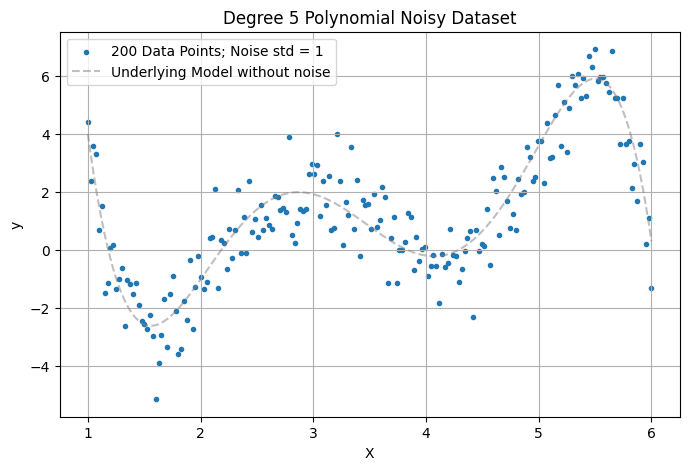

In [109]:
# Play around with various values here just to see what it does
# Make sure you see that the plot will change the scale as the data changes -- always watch the y-axis scale!

X,y = make_poly_model(n_samples=200,
                      degree=5,               # try values in the range 2 .. 6. 
                      noise=1,             # try values in the range 0 .. 10 and make sure to try values < 1. 
                      show_data=True,
                      random_state=None
                     )

### Part A: Create a dataset with the following parameters:

    n_samples = 200
    degree = 5
    noise = 10
    random_state = random_seed

(leaving the others at the defaults) and then split the data into **training** and
**held-out evaluation** sets using sklearn’s `train_test_split`, with 70% of the data
used for training and 30% held out for evaluation (`test_size=0.3`).

**Note:** Although the sklearn function uses the term *test* for the held-out
portion, in this assignment we use that split strictly as an **evaluation set** for
model comparison. Later in the course, we will reserve the term *test set* for final,
one-time performance assessment.


In [110]:
# Your code here

# Create the dataset
x, y = make_poly_model(
    n_samples=200,
    degree=5,
    noise=10,
    random_state=random_seed
)

In [111]:
# Visualize x
x[0:5]

array([[1.        ],
       [1.02512563],
       [1.05025126],
       [1.07537688],
       [1.10050251]])

In [112]:
# Visualize y
y[0:5]

array([ 8.96714153,  1.91606416,  9.12460262, 17.27528997, -0.85299601])

In [113]:
# Split the data into training and held out for evaluation sets

x_train, x_held, y_train ,y_held = train_test_split(
    x,
    y,
    test_size=0.3
)

### Graded Question

Assign `a1a` to the number of samples (rows) in `X_train`. 

In [114]:
# Your answer here. Use an expression, not a constant from visual inspection.

a1a = x_train.shape[0]                     # Replace 0 with an expression

In [115]:
# Do not change this cell in any way

print(f'a1a = {a1a}')

a1a = 140


### Part B: Investigating the model selection problem using evaluation/train plots

In this part, you will complete the template below to:
- Train polynomial models of degree 1 .. 10 on the training dataset (of degree 5) just produced in Part A;
- Calculate the training MSE and the evaluation MSE for each model;
- Plot the two MSE curves versus model degree (on the x axis) and
- Print out the minimal evaluation MSE found, and the "best" model which produced this result.
- Answer the graded question

In the remaining parts of the problem, you will answer questions about this plot. 


In [116]:
model = LinearRegression()

In [117]:
# FIX: reshape inputs so PolynomialFeatures works 
x_train = x_train.reshape(-1, 1) 
x_held = x_held.reshape(-1, 1)

In [118]:
x[0:5]

array([[1.        ],
       [1.02512563],
       [1.05025126],
       [1.07537688],
       [1.10050251]])

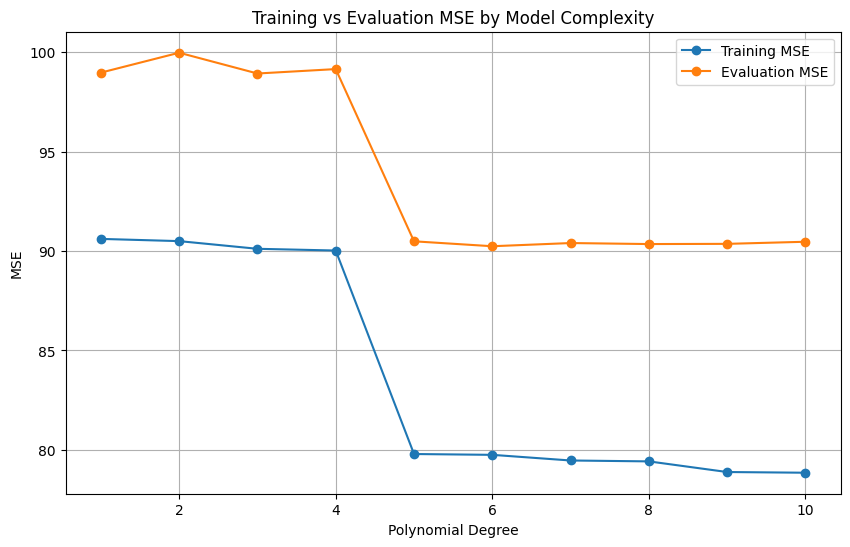

The min eval mse is : 90.2441080823119 and the best degress is 6


In [119]:
# Template for Problem One Part C

degrees = range(1,11) # try polynomials of these degrees
train_errors = []     # store training MSEs for each degree here
evaluation_errors  = []     # store evaluation MSEs for each degree here

for d in degrees:

    pass             # remove: just to get the cell to run without error

    # Use PolynomialFeatures to transform the data into appropriate form for
    # a polynomial model of degree d.
    
    poly = PolynomialFeatures(degree=d) 
    x_train_poly = poly.fit_transform(x_train) 
    x_held_poly = poly.transform(x_held)

    # Fit a linear regression model on the transformed data

    model.fit(x_train_poly, y_train)

    # Predict on the train and evaluation sets

    y_train_pred = model.predict(x_train_poly)
    y_held_pred = model.predict(x_held_poly)

    # Calculate the MSEs and append to the appropriate lists

    train_errors.append(mean_squared_error(y_train, y_train_pred))
    evaluation_errors.append(mean_squared_error(y_held, y_held_pred))

    
# Plot training and evaluation MSEs vs degree of model using train_errors and evaluation_errors
# Note that the x axis should have ticks for 1 .. 10 only

plt.figure(figsize=(10, 6))
plt.plot(degrees, train_errors, marker='o', label='Training MSE')
plt.plot(degrees, evaluation_errors, marker='o', label='Evaluation MSE')
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.title("Training vs Evaluation MSE by Model Complexity")
plt.legend()
plt.grid(True)
plt.show()


# Calculate and print out the minimal MSE for evaluation set and degree where it was obtained 
# Hint: notice carefully that the MSE lists are for degrees [1, 2, 3, ....]  (i.e., index + 1)

min_eval_mse = min(evaluation_errors) 
best_degree = degrees[evaluation_errors.index(min_eval_mse)]
print(f"The min eval mse is : {min_eval_mse} and the best degress is {best_degree}")

### Graded Question

Set `a1b` to the minimum evaluation MSE found for the given parameter choices.

In [120]:
# Your answer here. Use an expression, not a constant from visual inspection.

a1b = min_eval_mse                     # Replace 0 with an expression

In [121]:
# Do not change this cell in any way

print(f'a1b = {a1b:.4f}')              

a1b = 90.2441


### Prelude to Parts C, D, and E

For the remaining parts of this problem, you will **reuse the code from Parts A and B**
and run *additional experiments* to observe how the training and evaluation MSE curves
change under different data conditions.

Specifically, you should temporarily modify **one parameter at a time** in the data-
generation step from Part A, then re-run the Part B code to regenerate the MSE plot.

Experiment with the following parameter values:

- `n_samples`: 10, 20, 50, 100, 200, 500, 1000  
- `noise`: 0, 5, 10, 20, 50, 100, 500, 1000  
- `random_state`: set to `None` (you may repeat runs to observe variability)

You do **not** need to try all combinations. It is sufficient to change **each parameter
separately**, resulting in a total of 7 + 8 = 15 experiments.

**Important:** These experiments are *exploratory only*.  
After completing them, **reset all parameters to their original values from Part A**
before answering the graded questions that follow.

To avoid accidentally overwriting earlier results, you may either:
- reset the parameter values before proceeding, **or**
- add new code cells and copy only the minimal code needed to run these experiments.

The graded answers for Parts C–E should be based on patterns you observed across these
experiments—not on a single modified run.




### Part C: Training MSE

Set the variable to the single **most correct** answer.

Throughout all your experiments, the training MSE curve in the plot in Part B appears to

1. Fluctuate unpredictably.
2. Never increase (gets smaller or stays the same in each step).
3. Decrease rapidly to degree 5 and then flatten out (not change much).
4. Always be higher than the evaluation MSE.

In [122]:
# Your answer here. 

a1c = 2                    # Must be one of 1, 2, 3, 4

In [123]:
# Do not change this cell in any way

print(f'a1c = {a1c}')

a1c = 2


### Part D: Effect of No Noise 

If we leave all parameters the same as in our original Part B problem, **except** we set noise to 0, we will get the following plot, where the MSE is 0 for all degrees 5 and higher. 

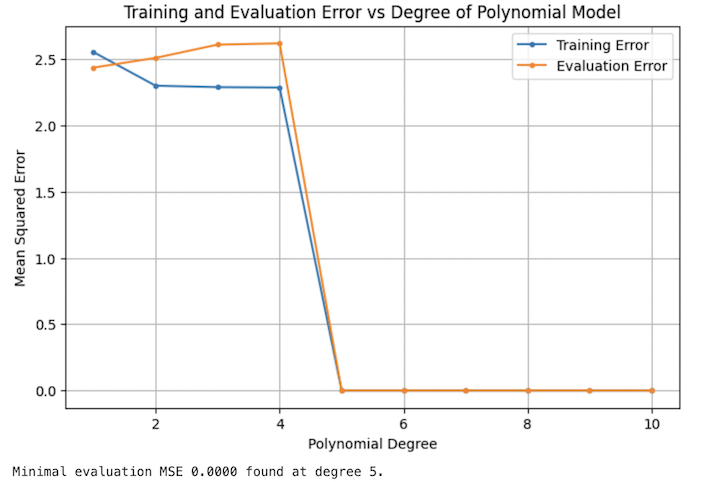

Why does the plot have MSE = 0 for degrees 5 and higher? Set the variable to the single **most correct** reason.

1. With noise set to zero, the training and evaluation samples become identical, so any model (degree ≥ 5) will predict perfectly.
2. Ordinary least squares yields zero error whenever the number of model parameters equals the number of data points, which happens here for degree ≥ 5.
3. Removing noise makes the variance component of MSE disappear, causing the MSE to be zero for all models of degree 5 or above.
4. The degree-5 model exactly matches the true data-generating polynomial, and any higher-degree fit can simply set its extra coefficients to zero—so predictions are perfect on both training and evaluation sets.

In [124]:
# Your answer here. 

a1d = 4                    # Must be one of 1, 2, 3, 4

In [125]:
# Do not change this cell in any way

print(f'a1d = {a1d}')

a1d = 4


### Part E: Effect of Increasing Amounts of Noise 

Suppose we leave all parameters the same as in our original Part B problem, **except** we set noise to increasingly larger values 0, 5, 10, 20, 50, 100, 500, 1000.

Set the variable to the single **most correct** answer regarding the plot. 

1. The best degree alternates between 5 and 6. 
2. The shapes of both plots is always essentially the same, the only change being the scale of the Y axis. 
3. The least MSE increases approximately proportionally to the square of the noise. 
4. The best degree found is always the same, and the least MSE increases approximately proportionally with the noise. 

In [126]:
# Your answer here. 

a1e = 3                    # Must be one of 1, 2, 3, 4

In [127]:
# Do not change this cell in any way

print(f'a1e = {a1e}')

a1e = 3


### Optional: Run more tests, with different degrees of polynomial as well!

If you have time to try more experiments, say by changing the degree, you will see that I chose the default parameters for our investigations
with some care, because you won't always get the beautiful curves shown in the textbooks, and you won't always get the correct degree when selecting
the "best" model based on the evaluation MSE. 

### Prelude to Problem Two

We have seen that it is possible to preprocess data by adding  new features which encode non-linear functions
of the existing features (in statistical learning theory, these are called "basis functions").  We have looked at only the simplest 
example, namely, extending a univariate regression problem with powers $x^2$, $x^3$, and so on. However, *basically* any non-linear function
of the features may be calculated and either added to, or replace, existing features. 

Examples of non-linear basis functions calculated from an existing feature $x$ and target $y$ include:

- **Polynomial Transforms** used in polynomial regression. In addition to new features such as $x^3$, when more than one feature occurs, we will get *Interaction Terms* such as $x_1x_2$. For example a quadratic polynomial regression on features $x_1$ and $x_2$ would create 3 new features: 
$$
y = \beta_0
+ \beta_1 x_1 + \beta_2 x_2
+ \beta_3 x_1^2 + \beta_4 x_2^2 + \beta_5 x_1 x_2
$$

- **Log Transforms** such as $\log(y)$ which (like using log scaling in a graph) helps scale a feature (or the target) if it ranges widely or exhibits exponential growth.

- **Exponentials** such as $2^{x_1}$ again helps scale a feature which exhibits exponential decay instead of exponential growth.

**Pause and ponder:** Why are added basis functions non-linear?   

## Problem Two: Linear Regression with Feature Engineering on the MPG Dataset

In this problem, we use the **Auto MPG dataset**, which contains various attributes of cars such as horsepower, weight, and engine displacement, to predict **fuel efficiency (MPG)** using linear regression. This dataset includes both numerical and categorical features, and as the histograms show, several variables are skewed or span multiple orders of magnitude. To improve model performance, we will apply some **feature engineering** techniques before fitting a linear regression model.



In [128]:
# Load the dataset
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = ['mpg','cylinders','displacement','horsepower','weight',
                'acceleration','model_year','origin','car_name']
# df = pd.read_csv(url, delim_whitespace=True, names=column_names, na_values='?')
df_mpg = pd.read_csv(url, sep=r'\s+', names=column_names, na_values='?')

In [129]:
df_mpg.info()

<class 'pandas.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    str    
dtypes: float64(5), int64(3), str(1)
memory usage: 28.1 KB


**Hm... let's look at that last feature, looks categorical...**

In [130]:
df_mpg['car_name']

0      chevrolet chevelle malibu
1              buick skylark 320
2             plymouth satellite
3                  amc rebel sst
4                    ford torino
                 ...            
393              ford mustang gl
394                    vw pickup
395                dodge rampage
396                  ford ranger
397                   chevy s-10
Name: car_name, Length: 398, dtype: str

**And they are almost all unique--doesn't look very useful for our task!**

In [131]:
len(df_mpg['car_name'].unique())

305

**Now, as always, let's look at the histograms -- in this particular data set the categorical feature will be ignored...**

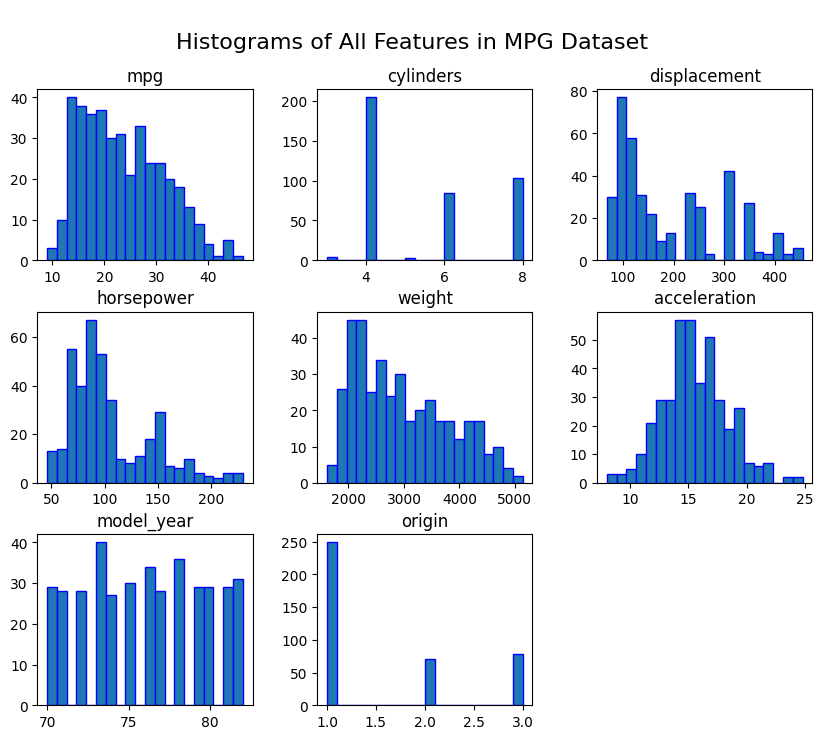

In [132]:
fig = df_mpg.hist(bins=20, figsize=(10, 8), layout=(3,3),grid=False,edgecolor='b')
plt.suptitle("\nHistograms of All Features in MPG Dataset", fontsize=16)
plt.show()

### Part A: Clean the Dataset

Before we can use the dataset for modeling, we need to address two issues:

1. **Irrelevant Categorical Feature**
   The `car_name` column has values that are mostly unique—305 distinct names in a dataset of 398 samples. This makes it an uninformative feature for modeling. Rather than encoding it, we will simply drop it. 

2. **Missing Values in `horsepower`**
   Some entries in the `horsepower` column are missing. While it's possible to impute these values, we will take a simpler approach for now and remove any rows with missing data.

**TODO:**

* Create a new DataFrame called `df_mpg_cleaned` that:

  * Drops the `car_name` column.
  * Remove rows where the `horsepower` value is missing (`NaN`).
  * Do **not** modify the original DataFrame `df_mpg`.
* Check out the new dataset using `.info()`

Hint: You can actually do the cleaning in one line using Pandas chaining methods. But two lines are fine :-). 


In [133]:
# Your code here -- add additional cells if you wish
df_mpg_cleaned = df_mpg.drop(["car_name"], axis=1)
df_mpg_cleaned = df_mpg_cleaned.dropna(subset=['horsepower'])
df_mpg_cleaned.info()

<class 'pandas.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    float64
 5   acceleration  392 non-null    float64
 6   model_year    392 non-null    int64  
 7   origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


### Graded Question

Assign `a2a` to the number of data samples in the cleaned dataset.

In [134]:
# Your answer here. Use an expression, not a constant from visual inspection.

a2a = df_mpg_cleaned.shape[0]                      # Replace 0 with an expression

In [135]:
# Do not change this cell in any way

print(f'a2a = {a2a}')

a2a = 392


### Part B: Build and Evaluate a Baseline Linear Regression Model

In this part, you’ll build a baseline linear regression model to predict `mpg` from the cleaned dataset and evaluate its performance.

**TODO:**

1. **Define your features and target**

   * Use all columns **except** `mpg` as features (`X`).
   * Use the `mpg` column as the target (`y`).
   * Tip: It’s best to keep `y` as a DataFrame, not a Series.

2. **Split the data into training and evaluation sets**

   * Use `train_test_split` from sklearn.
   * Set the test size to 20% and use `random_state=random_seed` to ensure reproducibility.
   * This should give you `X_train`, `X_eval`, `y_train`, and `y_eval` (if you wish, you may use `X_test` and `y_test`).

3. **Fit a linear regression model**

   * Create and train a `LinearRegression` model using the training data.

4. **Generate predictions**

   * Predict MPG values for both the training and evaluation sets.

5. **Evaluate the model**

   * Compute both **Root** Mean Squared Error (RMSE) and Mean Absolute Error (MAE) for the training and evaluation sets.
   * Print all four metrics with appropriate labels.

6. **Visualize the training results**

   * Make a scatter plot of predicted vs. actual MPG for the **training set**.
   * Add labels and a title to your plot to make it clear what’s being shown.

7. **Answer the graded questions**

>**Note:** If you examine your scatter plot carefully, you may notice that the points do not fall neatly along a straight line—especially at the low and high ends of the mpg scale. This suggests that the relationship between the features and the target is non-linear, and that applying some feature transformations could improve the model’s performance.


In [136]:
# Make a copy of the df
df_mpg_cleaned_copy = df_mpg_cleaned.copy()

In [137]:
# Your code here; add as many cells as you need

# Define x cols
x_cols = df_mpg_cleaned_copy.drop(['mpg'], axis=1)
x_cols

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,8,307.0,130.0,3504.0,12.0,70,1
1,8,350.0,165.0,3693.0,11.5,70,1
2,8,318.0,150.0,3436.0,11.0,70,1
3,8,304.0,150.0,3433.0,12.0,70,1
4,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...
393,4,140.0,86.0,2790.0,15.6,82,1
394,4,97.0,52.0,2130.0,24.6,82,2
395,4,135.0,84.0,2295.0,11.6,82,1
396,4,120.0,79.0,2625.0,18.6,82,1


In [138]:
# Define y cols
y_cols = df_mpg_cleaned_copy[['mpg']]
y_cols

,mpg
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0
...,...
393,27.0
394,44.0
395,32.0
396,28.0


In [153]:
# Split the data into train and test
x_train, x_eval, y_train, y_eval = train_test_split(
    x_cols,
    y_cols,
    test_size=0.20,
    random_state=random_seed
)

In [140]:
# Visualize the data
x_train

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
260,6,225.0,110.0,3620.0,18.7,78,1
184,4,140.0,92.0,2572.0,14.9,76,1
174,6,171.0,97.0,2984.0,14.5,75,1
64,8,318.0,150.0,4135.0,13.5,72,1
344,4,86.0,64.0,1875.0,16.4,81,1
...,...,...,...,...,...,...,...
72,8,304.0,150.0,3892.0,12.5,72,1
107,6,232.0,100.0,2789.0,15.0,73,1
272,4,151.0,85.0,2855.0,17.6,78,1
352,4,98.0,65.0,2380.0,20.7,81,1


In [158]:
car_model = LinearRegression()

In [159]:
# Fit the training data
car_model.fit(x_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [161]:
# Predict MPG for the train set
y_train_pred = car_model.predict(x_train)
y_train_pred

array([[20.45653375],
       [25.0040304 ],
       [21.3610419 ],
       [12.35126383],
       [32.96095953],
       [15.36057727],
       [34.0371074 ],
       [26.9210327 ],
       [23.38629422],
       [16.83508834],
       [16.92298203],
       [25.53050836],
       [26.74808368],
       [32.54361519],
       [29.36746433],
       [21.19470788],
       [18.15606668],
       [20.60111007],
       [10.12105887],
       [29.65900668],
       [19.27306418],
       [ 9.639425  ],
       [16.56859691],
       [ 9.99761006],
       [27.08013558],
       [29.46726123],
       [32.06929605],
       [36.892439  ],
       [23.84716377],
       [23.12886276],
       [19.98269873],
       [36.3879433 ],
       [32.53698408],
       [23.97463608],
       [22.91772644],
       [34.51443534],
       [31.31407564],
       [19.61600178],
       [22.20828098],
       [26.64768824],
       [20.71125276],
       [31.83597118],
       [20.17704617],
       [19.65600519],
       [36.40803844],
       [24

In [162]:
# Predict MPG for the eval set
y_eval_pred = car_model.predict(x_eval)
y_eval_pred

array([[25.84156153],
       [26.03674454],
       [34.50601837],
       [24.89553187],
       [28.42598707],
       [30.56138237],
       [ 8.58694262],
       [30.7218562 ],
       [20.55678574],
       [28.64682346],
       [12.61214902],
       [25.2643465 ],
       [16.77369622],
       [29.68019379],
       [21.82299683],
       [29.24834035],
       [20.39502626],
       [33.38385417],
       [26.67772934],
       [29.95149498],
       [18.93820309],
       [34.50905163],
       [35.48745148],
       [14.89405823],
       [28.45593435],
       [25.63054631],
       [21.02578033],
       [16.17903858],
       [28.69605142],
       [24.09256378],
       [13.39025838],
       [23.44947094],
       [20.79944762],
       [31.89302231],
       [12.28040099],
       [36.22266955],
       [10.8636647 ],
       [24.36542068],
       [11.44089858],
       [ 7.13672588],
       [12.8573181 ],
       [27.56118055],
       [34.72959156],
       [26.38589426],
       [11.98975421],
       [ 9

In [164]:
# RMSE for the train set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_rmse

np.float64(3.3134960151437456)

In [165]:
# RMSE for the eval set
eval_rmse = np.sqrt(mean_squared_error(y_eval, y_eval_pred))
eval_rmse

np.float64(3.2727457003009515)

In [166]:
# MAE for the train set
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mae

2.5481681962151357

In [167]:
# MAE for the eval set
eval_mae = mean_absolute_error(y_eval, y_eval_pred)
eval_mae

2.4197802491974496

In [174]:
y_train_pred.shape[0]

313

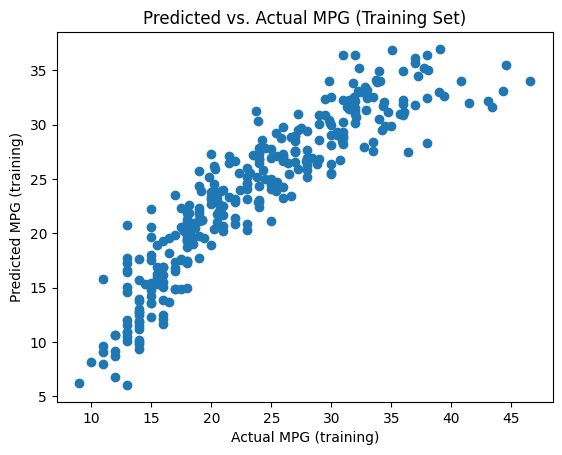

In [180]:
# Scatter plot predicted vs. actual MPG for the training set
plt.scatter(y_train, y_train_pred)
plt.xlabel("Actual MPG (training)")
plt.ylabel("Predicted MPG (training)")
plt.title("Predicted vs. Actual MPG (Training Set)")
plt.show()


### Graded Question

Assign `a2b` to the evaluation MAE just calculated. 

In [181]:
# Your answer here. Use an expression, not a constant from visual inspection.

a2b = eval_mae                     # Replace 0 with an expression

In [182]:
# Do not change this cell in any way

print(f'a2b = {a2b:.4f}')

a2b = 2.4198


### Part C: Build and evaluate a model with non-linear feature transformations

Now you must essentially repeat what you did in Part B, but after adding the following three engineered features 
to `X`. 

### Square-root transform of horsepower

The `horsepower` variable is right-skewed, with a long tail of high values. We apply a square-root transformation to reduce skewness and compress the scale of extreme values:

$$
    \text{SqrtHP} = \sqrt{\text{Horsepower}}
$$

This helps the model treat high-horsepower cars more smoothly without being dominated by a few large values.



### Log-transform of weight

Car weight ranges widely and is heavily skewed, as shown in the histogram. We add a log-transformed feature:

$$
    \text{LogWeight} = \log(1 + \text{Weight})
$$

This transformation preserves order but compresses extreme values, allowing the model to better capture the non-linear influence of weight on fuel efficiency. 

**Note:** $log(1 + x)$ (also known as `log1p(x)` in numpy) is a common transformation because it behaves well across both small and large values, and avoids the error associated with 0 values in the data. 



### Interaction term for displacement and cylinders

We hypothesize that the effect of engine displacement on MPG may depend on the number of cylinders, since larger engines typically have more cylinders. To model this interaction, we include:

$$
    \text{DispXyl} = \text{Displacement} \times \text{Cylinders}
$$

This allows the model to capture joint effects that wouldn’t be possible with separate linear terms.



**Note:** As in most modeling workflows, and **add** (not replace) new transformed features to enrich the model. In future lessons, we will explore how to evaluate the usefulness of these features and eliminate any that may add noise or redundancy.

**TODO:**

- Add these features to `X`
- Complete all steps from Part B, but for this new dataset
- Answer the graded question

In [183]:
# Your code here; add as many cells as you need

# Add sqrt horsepower
df_mpg_cleaned['horsepower_sqrt'] = df_mpg_cleaned['horsepower'] ** (0.5)
df_mpg_cleaned



,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,horsepower_sqrt
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,11.401754
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,12.845233
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,12.247449
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,12.247449
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,11.832160
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,9.273618
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,7.211103
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,9.165151
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,8.888194


In [185]:
# Add the log of weight column
df_mpg_cleaned['log_weight'] = np.log1p(df_mpg_cleaned['weight'])
df_mpg_cleaned

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,horsepower_sqrt,log_weight
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,11.401754,8.161946
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,12.845233,8.214465
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,12.247449,8.142354
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,12.247449,8.141481
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,11.832160,8.146130
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,9.273618,7.934155
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,7.211103,7.664347
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,9.165151,7.738924
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,8.888194,7.873217


In [186]:
# Add the DispXyl column
df_mpg_cleaned['DispXyl'] = df_mpg_cleaned['displacement'] * df_mpg_cleaned['cylinders']
df_mpg_cleaned

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,horsepower_sqrt,log_weight,DispXyl
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,11.401754,8.161946,2456.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,12.845233,8.214465,2800.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,12.247449,8.142354,2544.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,12.247449,8.141481,2432.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,11.832160,8.146130,2416.0
...,...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,9.273618,7.934155,560.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,7.211103,7.664347,388.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,9.165151,7.738924,540.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,8.888194,7.873217,480.0


In [191]:
# Make a copy of the df
df_mpg_cleaned_copy_2 = df_mpg_cleaned.copy()
df_mpg_cleaned_copy_2

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,horsepower_sqrt,log_weight,DispXyl
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,11.401754,8.161946,2456.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,12.845233,8.214465,2800.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,12.247449,8.142354,2544.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,12.247449,8.141481,2432.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,11.832160,8.146130,2416.0
...,...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,9.273618,7.934155,560.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,7.211103,7.664347,388.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,9.165151,7.738924,540.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,8.888194,7.873217,480.0


In [192]:
# Define x cols
x_cols_2 = df_mpg_cleaned_copy_2.drop(['mpg'], axis=1)
x_cols_2

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,horsepower_sqrt,log_weight,DispXyl
0,8,307.0,130.0,3504.0,12.0,70,1,11.401754,8.161946,2456.0
1,8,350.0,165.0,3693.0,11.5,70,1,12.845233,8.214465,2800.0
2,8,318.0,150.0,3436.0,11.0,70,1,12.247449,8.142354,2544.0
3,8,304.0,150.0,3433.0,12.0,70,1,12.247449,8.141481,2432.0
4,8,302.0,140.0,3449.0,10.5,70,1,11.832160,8.146130,2416.0
...,...,...,...,...,...,...,...,...,...,...
393,4,140.0,86.0,2790.0,15.6,82,1,9.273618,7.934155,560.0
394,4,97.0,52.0,2130.0,24.6,82,2,7.211103,7.664347,388.0
395,4,135.0,84.0,2295.0,11.6,82,1,9.165151,7.738924,540.0
396,4,120.0,79.0,2625.0,18.6,82,1,8.888194,7.873217,480.0


In [193]:
# Define y cols
y_cols_2 = df_mpg_cleaned_copy_2[['mpg']]
y_cols_2

,mpg
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0
...,...
393,27.0
394,44.0
395,32.0
396,28.0


In [194]:
# Split the data into train and test
x_train, x_eval, y_train, y_eval = train_test_split(
    x_cols_2,
    y_cols_2,
    test_size=0.20,
    random_state=random_seed
)

In [197]:
# Visualize the data
x_train

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,horsepower_sqrt,log_weight,DispXyl
260,6,225.0,110.0,3620.0,18.7,78,1,10.488088,8.194506,1350.0
184,4,140.0,92.0,2572.0,14.9,76,1,9.591663,7.852828,560.0
174,6,171.0,97.0,2984.0,14.5,75,1,9.848858,8.001355,1026.0
64,8,318.0,150.0,4135.0,13.5,72,1,12.247449,8.327484,2544.0
344,4,86.0,64.0,1875.0,16.4,81,1,8.000000,7.536897,344.0
...,...,...,...,...,...,...,...,...,...,...
72,8,304.0,150.0,3892.0,12.5,72,1,12.247449,8.266935,2432.0
107,6,232.0,100.0,2789.0,15.0,73,1,10.000000,7.933797,1392.0
272,4,151.0,85.0,2855.0,17.6,78,1,9.219544,7.957177,604.0
352,4,98.0,65.0,2380.0,20.7,81,1,8.062258,7.775276,392.0


In [198]:
car_model_2 = LinearRegression()

In [199]:
# Fit the training data
car_model_2.fit(x_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [200]:
# Predict MPG for the train set
y_train_pred = car_model_2.predict(x_train)
y_train_pred

array([[18.88486604],
       [24.30504271],
       [21.02085271],
       [12.83254331],
       [36.16591604],
       [16.6229226 ],
       [37.04327954],
       [24.89567832],
       [21.18711516],
       [17.18153073],
       [16.50179433],
       [25.1975636 ],
       [27.26828957],
       [33.31844934],
       [29.76053472],
       [19.31267432],
       [17.95221776],
       [19.22919488],
       [12.61204989],
       [27.48066064],
       [17.44449662],
       [12.94804295],
       [15.2312428 ],
       [12.82903596],
       [31.62626997],
       [32.27374239],
       [34.84231251],
       [39.49698019],
       [23.43735748],
       [22.65622157],
       [18.85289848],
       [37.57464334],
       [34.48089965],
       [23.31449904],
       [22.61978994],
       [35.9450794 ],
       [29.12319847],
       [18.66987055],
       [21.74338771],
       [24.23954942],
       [19.3742857 ],
       [29.87627193],
       [18.80580625],
       [17.65118864],
       [36.85802418],
       [23

In [201]:
# Predict MPG for the eval set
y_eval_pred = car_model_2.predict(x_eval)
y_eval_pred

array([[26.7228227 ],
       [23.85115807],
       [36.69056324],
       [25.68697956],
       [28.581862  ],
       [30.26016881],
       [11.15519407],
       [29.97907859],
       [19.55614861],
       [33.57329962],
       [13.16678108],
       [22.49059615],
       [17.34337681],
       [29.50763761],
       [20.18853411],
       [28.36056617],
       [19.3331822 ],
       [32.89266274],
       [27.9084306 ],
       [29.15238466],
       [17.4294932 ],
       [36.48175405],
       [36.4227661 ],
       [13.75047917],
       [30.78836747],
       [24.81039225],
       [20.06525681],
       [15.18303554],
       [33.0824555 ],
       [23.73618644],
       [14.53699012],
       [22.20524842],
       [19.91890378],
       [31.22897121],
       [13.33122689],
       [37.26030699],
       [13.07918796],
       [24.80426756],
       [12.1171888 ],
       [10.90839719],
       [13.3896491 ],
       [28.48688723],
       [35.43321289],
       [27.21898103],
       [14.24595352],
       [13

In [203]:
# RMSE for the train set
train_rmse_2 = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_rmse_2

np.float64(2.8419112718593498)

In [204]:
# RMSE for the eval set
eval_rmse_2 = np.sqrt(mean_squared_error(y_eval, y_eval_pred))
eval_rmse_2

np.float64(3.000222296800321)

In [205]:
# MAE for the train set
train_mae_2 = mean_absolute_error(y_train, y_train_pred)
train_mae_2

2.064823830699359

In [206]:
# MAE for the eval set
eval_mae_2 = mean_absolute_error(y_eval, y_eval_pred)
eval_mae_2

2.201841657435828

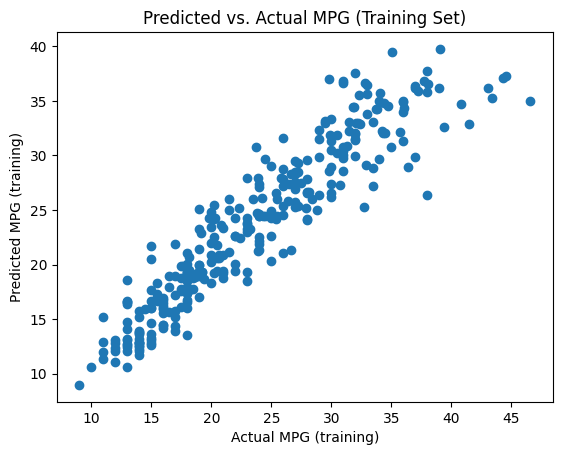

In [207]:
# Scatter plot predicted vs. actual MPG for the training set
plt.scatter(y_train, y_train_pred)
plt.xlabel("Actual MPG (training)")
plt.ylabel("Predicted MPG (training)")
plt.title("Predicted vs. Actual MPG (Training Set)")
plt.show()

### Graded Question

Assign `a2c` to the evaluation RMSE just calculated. 

In [208]:
# Your answer here. Use an expression, not a constant from visual inspection.

a2c = eval_rmse_2                     # Replace 0 with an expression

In [209]:
# Do not change this cell in any way

print(f'a2c = {a2c:.4f}')

a2c = 3.0002


### Part D: Present and summarize your results

**TODO:**

1. **Create a visual comparison of model performance**

   * Create a **bar chart** that compares baseline and feature-engineered models.
   * Include the following eight metric values:

     * Training RMSE (baseline vs. feature-engineered)
     * Evaluation RMSE (baseline vs. feature-engineered)
     * Training MAE (baseline vs. feature-engineered)
     * Evaluation MAE (baseline vs. feature-engineered)
   * Tip: It is acceptable to ask ChatGPT to help generate this chart.

2. **Compute absolute reductions**

   For both **training** and **evaluation** metrics:

   * Compute the **absolute reduction** in RMSE:

     * baseline RMSE − feature-engineered RMSE
   * Compute the **absolute reduction** in MAE:

     * baseline MAE − feature-engineered MAE

3. **Compute percent reductions**

   For both **training** and **evaluation** metrics:

   * Compute the **percent reduction** in RMSE.
   * Compute the **percent reduction** in MAE.

   *(You should report a total of eight reduction values.)*

4. **Interpret the results**

   * Answer the **graded question**, using both the numerical results and the bar chart to support your conclusions.

---

### **Hint: How to compute reductions**

Suppose the following values are observed for a given metric (e.g., MAE):

* Baseline MAE = 5.00
* Feature-engineered MAE = 4.00

1. **Absolute reduction**

$$
\Delta \text{MAE}
= \text{baseline\_MAE} - \text{new\_MAE} \\
= 5.00 - 4.00 \\
= 1.0000
$$

2. **Percent reduction**

$$
\%\text{Reduction}
= \frac{\text{baseline\_MAE} - \text{new\_MAE}}{\text{baseline\_MAE}} \\
= \frac{1.00}{5.00} \\
= 0.2000
$$



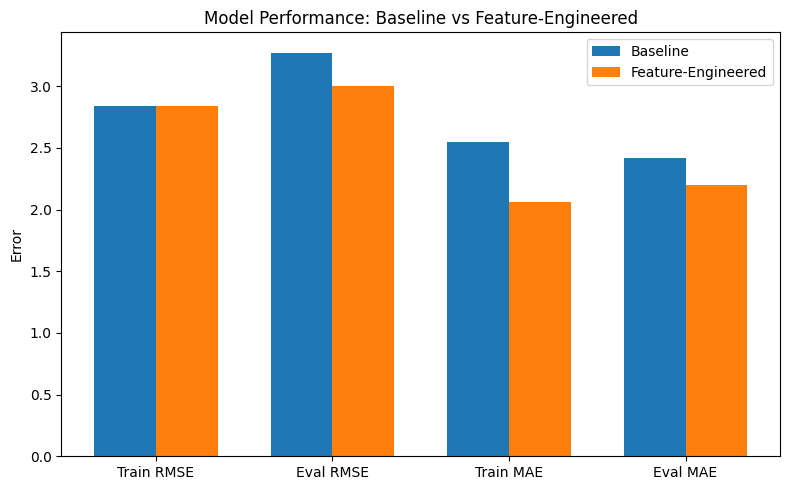

In [210]:
# Your code here; add as many cells as you need
# Plotting the values

metrics = ["Train RMSE", "Eval RMSE", "Train MAE", "Eval MAE"]

baseline_vals = [train_rmse, eval_rmse, train_mae, eval_mae]
fe_vals       = [train_rmse_2, eval_rmse_2, train_mae_2, eval_mae_2]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, baseline_vals, width, label='Baseline')
plt.bar(x + width/2, fe_vals,       width, label='Feature-Engineered')

plt.xticks(x, metrics)
plt.ylabel("Error")
plt.title("Model Performance: Baseline vs Feature-Engineered")
plt.legend()
plt.tight_layout()
plt.show()

In [213]:
# Compute Absolute Reduction in RMSE
print(f"Training absolute reduction in RMSE: {train_rmse - train_rmse_2}")
print(f"Eval absolute reduction in RMSE: {eval_rmse - eval_rmse_2}")

Training absolute reduction in RMSE: 0.0
Eval absolute reduction in RMSE: 0.2725234035006303


In [214]:
# Compute Absolute Reduction in MAE
print(f"Training absolute reduction in MAE: {train_mae - train_mae_2}")
print(f"Eval absolute reduction in MAE: {eval_mae - eval_mae_2}")

Training absolute reduction in MAE: 0.48334436551577653
Eval absolute reduction in MAE: 0.21793859176162167


In [217]:
# Compute Percent Reduction in RMSE
print(f"Training percent reduction in RMSE: {(train_rmse - train_rmse_2)/train_rmse}")
print(f"Eval percent reduction in RMSE: {(eval_rmse - eval_rmse_2)/eval_rmse}")

Training percent reduction in RMSE: 0.0
Eval percent reduction in RMSE: 0.0832705710912919


In [218]:
# Compute Percent Reduction in MAE
print(f"Training percent reduction in MAE: {(train_mae - train_mae_2)/train_mae}")
print(f"Eval percent reduction in MAE: {(eval_mae - eval_mae_2)/eval_mae}")

Training percent reduction in MAE: 0.18968306967872106
Eval percent reduction in MAE: 0.0900654478165543


### Graded Question

Assign `a2d` to the percent reduction in the evaluation MAE. 

In [220]:
# Your answer here. Use an expression, not a constant from visual inspection.

a2d = ((eval_mae - eval_mae_2)/eval_mae)                    # Replace 0 with an expression

In [221]:
# Do not change this cell in any way

print(f'a2d = {a2d:.4f}')

a2d = 0.0901


Mean MSE over all 1000 Trials: 100.3668


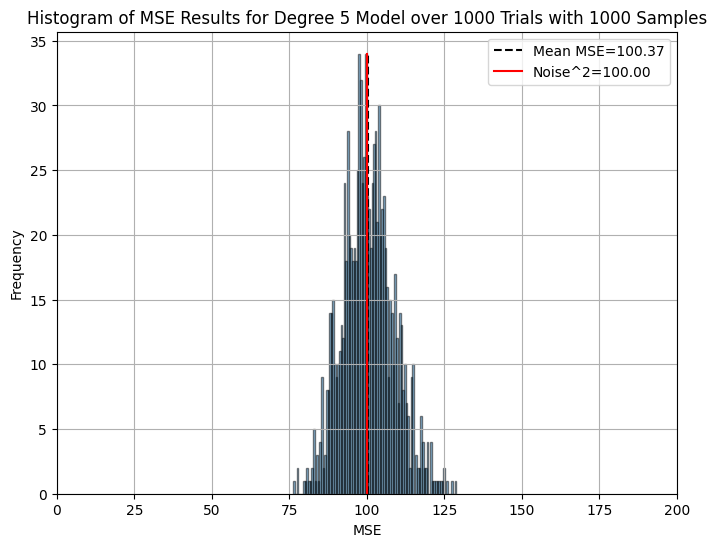

In [222]:

mses = []



n_samples = 1000
degree = 5
model_degree = 5
noise=10
test_size = 0.3

for _ in range(1000):

    X_full,y_full = make_poly_model( n_samples=n_samples,degree=degree,
                                     noise=noise,show_data=False,show_model=False,
                                     random_state=None
                                   ) 

    X_train, X_eval, y_train, y_eval = train_test_split( X_full, 
                                                       y_full, 
                                                       test_size=test_size, 
                                                       random_state=None
                                                     )

    # Use PolynomialFeatures to transform the data into appropriate form for
    # a polynomial model of degree d.
    poly = PolynomialFeatures(degree=model_degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_eval_poly  = poly.transform(X_eval)

    # Fit a linear regression on the transformed data
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Predict on train and evaluation sets
    y_eval_pred  = model.predict(X_eval_poly)

    # Calculate the MSEs and append to the appropriate list
    evaluation_mse  = mean_squared_error(y_eval, y_eval_pred)

    mses.append(evaluation_mse)

mu = np.mean(mses)
print(f'Mean MSE over all {len(mses)} Trials: {mu:.4f}')
plt.figure(figsize=(8,6))
plt.title(f'Histogram of MSE Results for Degree {model_degree} Model over {len(mses)} Trials with {n_samples} Samples')
n,_,_ = plt.hist(mses,bins=100,edgecolor='black',alpha=0.5)
ub = np.max(n)
plt.plot([mu,mu],[0,ub],linestyle='--',label=f'Mean MSE={mu:.2f}',color='black')
plt.plot([noise**2,noise**2],[0,ub],label=f'Noise^2={noise**2:.2f}',color='red')
plt.legend()
plt.xlim(0,200)
plt.ylabel('Frequency')
plt.xlabel('MSE')
plt.grid()
plt.show()